In [135]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, linregress
import pandas as pd
import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from backpack import backpack, extend
from backpack.extensions import DiagHessian, KFAC, DiagGGNExact

plt.rcParams["figure.figsize"] = (20,10)

In [136]:
s= 10
np.random.seed(s)
torch.manual_seed(s)
torch.cuda.manual_seed(s)

In [185]:
class IrisDataset(data.Dataset):
    def __init__(self, train=True):
        super(IrisDataset, self).__init__()

        iris = load_iris()

        X, y = iris.data, iris.target
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

        if train:
            self.inputs, self.labels = X_train, y_train

        else:
            self.inputs, self.labels = X_test, y_test

    def __getitem__(self, index):
        inp = torch.Tensor(self.inputs[index])
        label = torch.LongTensor([self.labels[index]])
        return inp, label

    def __len__(self):
        return len(self.inputs)

dataloader = data.DataLoader(IrisDataset(train=True), batch_size=32, shuffle=True, num_workers=0)
testloader = data.DataLoader(IrisDataset(train=False), batch_size=32, shuffle=False, num_workers=0)

In [138]:
def metric(inferred_tensor: torch.Tensor, ground_truth: torch.Tensor) -> torch.Tensor:
        """Classification Accuracy
        example)
        inferred_tensor: [[0,0,1], [0,1,0]]
        ground_truth: [2, 0]
        return: 0.5
        :param inferred_tensor: (torch.Tensor) [batch_size, n_classes(3)], inferred logits
        :param ground_truth:  (torch.LongTensor) [batch_size], ground truth labels
                                each consisting LongTensor ranging from 0 to 2
        :return: (torch.Tensor) metric
        """

        inferred_tensor = torch.argmax(inferred_tensor, dim=-1)
        acc = torch.mean((inferred_tensor == ground_truth).to(torch.float), dim=-1)
        return acc

def flattenlist(lst):
    flat_list = []
    for sublist in lst:
        for item in sublist:
            flat_list.append(item)
    return flat_list

In [139]:
def NN(sz):
    
    features = torch.nn.Sequential(
        torch.nn.Linear(4, sz),
        torch.nn.Linear(sz, sz),
        torch.nn.Linear(sz, sz),
        torch.nn.Linear(sz, sz),
        torch.nn.Linear(sz, sz),
        #extension starts here
        torch.nn.Linear(sz, 3)
        
    )
    return(features)

def NN_deep(sz):
    
    features = torch.nn.Sequential(
        torch.nn.Linear(4, sz),
        torch.nn.Linear(sz, sz),
        torch.nn.Linear(sz, sz),
        torch.nn.Linear(sz, sz),
        torch.nn.Linear(sz, sz),
        #extension starts here
        torch.nn.Linear(sz, sz),
        torch.nn.Linear(sz, sz),
        torch.nn.Linear(sz, sz),
        torch.nn.Linear(sz, sz),
        torch.nn.Linear(sz, 3)
        
    )
    return(features)



In [140]:
def train_iris(model, criterion, optim, num_epochs, device = 'cpu'):
    for epoch in range(num_epochs):
        #계산을 하기 위해서 loss를 저장하는 변수(모니터링 용)
        train_loss = torch.Tensor([0]).to(device)
        train_acc = torch.Tensor([0]).to(device)

        for x, y in dataloader:
            x = x.to(device)
            y= y.squeeze(-1).to(device)

            optimizer.zero_grad()
            y_ = model(x)

            loss = criterion(y_, y)
            train_loss +=loss
            loss.backward()
            optimizer.step()

            acc = metric(y_, y)
            train_acc += acc

        train_loss /= len(dataloader)
        train_acc /= len(dataloader)

        print('[{curr}/{tot}] >Loss: {loss:.2f}, Acc: {acc:.2f}%'.format(
            curr = epoch+1,
            tot = num_epochs,
            loss = train_loss.detach().cpu().item(),
            acc = float(100*train_acc.detach().cpu().item())
        ))




        


In [141]:
def get_accuracy(output, targets):
    """Helper function to print the accuracy"""
    predictions = output.argmax(dim=1, keepdim=True).view_as(targets)
    return predictions.eq(targets).float().mean().item()

In [142]:
#train_iris(net, lossfunction, optimizer, 100)

In [143]:
def get_Hessian_NN(model, train_loader, prec0, device='cpu', verbose=False):
    lossfunc = lossfunction

    extend(lossfunc, debug=False)
    extend(model, debug=False)

    Cov_diag = []
    for param in model.parameters():
        ps = param.size()
        #print("parameter size: ", ps)
        Cov_diag.append(torch.zeros(ps, device=device))
        #print(param.numel())

    #var0 = 1/prec0
    #max_len = len(train_loader)
    #for param in model.parameters():
    #    print(torch.mean(param))
    
    #model.eval()
    #acctemp = []
    #max_len = len(train_loader)
    #for batch_idx, (x, y) in enumerate(train_loader):
    #        output = model(x)
    #        accuracy = get_accuracy(output, y)
            #if batch_idx % 30 == 0:
               # print(
               #     "Batch {}/{} \t".format(batch_idx, max_len) + 
               #     "Accuracy %.0f" % (accuracy * 100) + "%"
               # )
    #        acctemp.append(accuracy)

    #print(np.mean(acctemp))
    #model.train()

    with backpack(DiagHessian()):

        for batch_idx, (x, y) in enumerate(train_loader):
            
            
            #if device == 'cuda':
            #    x, y = x.float().cuda(), y.long().cuda()
            #else:
            #    x, y = torch.tensor(x).float(), torch.tensor(y).float()
            #print(x, y)
            x = x.to(device)
            y= y.squeeze(-1).to(device)

            model.zero_grad()
            #x, y = x.view(-1, 1), y.view(-1, 1) 
                        
            lossfunc(model(x), y).backward()

            with torch.no_grad():
                # Hessian of weight
                for idx, param in enumerate(model.parameters()):

                    H_ = param.diag_h
                    #print(H_)
                    #add prior here
                    H_ += prec0 * torch.ones(H_.size())
                    H_inv = torch.sqrt(1/H_) #<-- standard deviation
                    #H_inv = 1/H_              #<-- variance 

                    rho = 1-1/(batch_idx+1)

                    Cov_diag[idx] = rho*Cov_diag[idx] + (1-rho)* H_inv
            
            if verbose:
                print("Batch: {}/{}".format(batch_idx, max_len))
    print()
    #model.eval()
    #acctemp = []
    #max_len = len(train_loader)
    #for batch_idx, (x, y) in enumerate(train_loader):
    #        output = model(x)
    #        accuracy = get_accuracy(output, y)
    #       # if batch_idx % 30 == 0:
           #     print(
           #         "Batch {}/{} \t".format(batch_idx, max_len) + 
           #         "Accuracy %.0f" % (accuracy * 100) + "%"
           #     )
    #        acctemp.append(accuracy)

    #print(np.mean(acctemp))
    #model.train()

    #model.train()
    #for param in model.parameters():
    #    print(torch.mean(param))
    
    return(Cov_diag)

In [146]:
#for wd in [1,2, 4, 8, 16, 32, 64, 128, 512]:
#    net = NN(sz= wd)#

#    lossfunction = torch.nn.CrossEntropyLoss()
#    #optimizer = torch.optim.SGD(net.parameters(), lr=0.1, momentum=0.5)
#    optimizer = torch.optim.Adam(net.parameters(), lr= 0.001)
#    if wd == 1:
#        train_iris(net, lossfunction, optimizer, 400)
#    else:
#        train_iris(net, lossfunction, optimizer, 250)
    
#    state = net.state_dict()
#    torch.save(state, '/Users/moreez/Desktop/BcThesis/VGG/NASex/iris/{}irisnet_seed{}'.format(wd, s))
    
#    curvature = get_Hessian_NN(net, train_loader=dataloader, prec0 = 0.001, verbose=False)
    
#    torch.save(curvature, '/Users/moreez/Desktop/BcThesis/VGG/NASex/iris/{}iriscurvature_seed{}'.format(wd, s))

In [145]:
#testnet = NN(sz=4)
#testHess = get_Hessian_NN(testnet, train_loader=dataloader, prec0 = 0.1, verbose=False)
#train_iris(NN(sz=2), lossfunction, torch.optim.Adam(net.parameters(), lr= 0.01), 100)

In [200]:
def get_acc(seed, testloader):    
    widths = [512, 128, 64, 32, 16, 8, 4, 2, 1]
    #widths = [8, 4, 2]
    acc = []
    for wdd in widths:
        model = NN(sz=wdd)
        
        DATAPATH = '/Users/moreez/Desktop/BcThesis/VGG/NASex/iris/{}irisnet_seed{}'.format(wdd, s)

        weights = torch.load(DATAPATH, map_location=torch.device('cpu')) 
        #print(weights.keys())
        keyss = weights.keys()
        topop = []
        for elem in keyss:
            if 'shape' in elem:
                topop.append(elem)
        for key in topop:
            weights.pop(key)
        #print(weights.keys())
        model.load_state_dict(weights, strict=True)
        model.eval()
        acctemp = []
        max_len = len(testloader)
        for batch_idx, (x, y) in enumerate(testloader):
                output = model(x)
                accuracy = get_accuracy(output, y)
                if batch_idx % 30 == 0:
                    print(
                        "Batch {}/{} \t".format(batch_idx, max_len) + 
                        "Accuracy %.0f" % (accuracy * 100) + "%"
                    )
                acctemp.append(accuracy)

        avg_acc = np.mean(acctemp)
        acc.append(avg_acc)

    #print(acc)
    return acc





In [190]:
def get_uncerts(seed):  
    
    
    widths = ['512', '128','64','32','16', '8', '4', '2', '1']

    avg_unc = []
    lastlayer_unc = []
    
    for wdd in widths:
        #if width == '16':
        #    accur = '80'
        #elif width in ['8','4','2']:
        #    DATAPATH = '/Users/moreez/Desktop/BcThesis/VGG/exx/Hess/bestHess/{}bes_ckpt_seed11.pth'.format(width)
        #else:
        #    accur = '90'
        #if path.exists('/Users/moreez/Desktop/BcThesis/VGG/exx/Hess/bestHess/{}vggHessian_prec00001_seed11_accur{}.pth'.format(width, accur)):
        #        print(width)    
        
        DATAPATH = '/Users/moreez/Desktop/BcThesis/VGG/NASex/iris/{}iriscurvature_seed{}'.format(wdd, s)
        
        #print(DATAPATH)
        hess = torch.load(DATAPATH, map_location=torch.device('cpu')) 
        temp = []
        for i, tnsr in enumerate(hess):
            if i%2 == 0:
                temp.append(torch.mean(tnsr).item())

        avg_unc.append(np.mean(temp))

        lastlayer_unc.append(torch.mean(hess[-2]).item())

    #print(avg_unc)
    #print(lastlayer_unc)
    return avg_unc, lastlayer_unc



In [202]:
allaccs= []
for i in range(1, 11):
    accc = get_acc(i, testloader)
    allaccs.append(accc)

Batch 0/1 	Accuracy 97%
Batch 0/1 	Accuracy 100%
Batch 0/1 	Accuracy 100%
Batch 0/1 	Accuracy 97%
Batch 0/1 	Accuracy 100%
Batch 0/1 	Accuracy 100%
Batch 0/1 	Accuracy 97%
Batch 0/1 	Accuracy 100%
Batch 0/1 	Accuracy 97%
Batch 0/1 	Accuracy 97%
Batch 0/1 	Accuracy 100%
Batch 0/1 	Accuracy 100%
Batch 0/1 	Accuracy 97%
Batch 0/1 	Accuracy 100%
Batch 0/1 	Accuracy 100%
Batch 0/1 	Accuracy 97%
Batch 0/1 	Accuracy 100%
Batch 0/1 	Accuracy 97%
Batch 0/1 	Accuracy 97%
Batch 0/1 	Accuracy 100%
Batch 0/1 	Accuracy 100%
Batch 0/1 	Accuracy 97%
Batch 0/1 	Accuracy 100%
Batch 0/1 	Accuracy 100%
Batch 0/1 	Accuracy 97%
Batch 0/1 	Accuracy 100%
Batch 0/1 	Accuracy 97%
Batch 0/1 	Accuracy 97%
Batch 0/1 	Accuracy 100%
Batch 0/1 	Accuracy 100%
Batch 0/1 	Accuracy 97%
Batch 0/1 	Accuracy 100%
Batch 0/1 	Accuracy 100%
Batch 0/1 	Accuracy 97%
Batch 0/1 	Accuracy 100%
Batch 0/1 	Accuracy 97%
Batch 0/1 	Accuracy 97%
Batch 0/1 	Accuracy 100%
Batch 0/1 	Accuracy 100%
Batch 0/1 	Accuracy 97%
Batch 0/1 	Accurac

In [206]:
print(allaccs)
meanacc = np.mean(allaccs, axis=0)
print(meanacc)

[[0.9666666388511658, 1.0, 1.0, 0.9666666388511658, 1.0, 1.0, 0.9666666388511658, 1.0, 0.9666666388511658], [0.9666666388511658, 1.0, 1.0, 0.9666666388511658, 1.0, 1.0, 0.9666666388511658, 1.0, 0.9666666388511658], [0.9666666388511658, 1.0, 1.0, 0.9666666388511658, 1.0, 1.0, 0.9666666388511658, 1.0, 0.9666666388511658], [0.9666666388511658, 1.0, 1.0, 0.9666666388511658, 1.0, 1.0, 0.9666666388511658, 1.0, 0.9666666388511658], [0.9666666388511658, 1.0, 1.0, 0.9666666388511658, 1.0, 1.0, 0.9666666388511658, 1.0, 0.9666666388511658], [0.9666666388511658, 1.0, 1.0, 0.9666666388511658, 1.0, 1.0, 0.9666666388511658, 1.0, 0.9666666388511658], [0.9666666388511658, 1.0, 1.0, 0.9666666388511658, 1.0, 1.0, 0.9666666388511658, 1.0, 0.9666666388511658], [0.9666666388511658, 1.0, 1.0, 0.9666666388511658, 1.0, 1.0, 0.9666666388511658, 1.0, 0.9666666388511658], [0.9666666388511658, 1.0, 1.0, 0.9666666388511658, 1.0, 1.0, 0.9666666388511658, 1.0, 0.9666666388511658], [0.9666666388511658, 1.0, 1.0, 0.966

In [180]:
aa, ba, ca, da, ea, fa, ga, ha, ia = [], [], [], [], [], [], [], [], []
al, bl, cl, dl, el, fl, gl, hl, il = [], [], [], [], [], [], [], [], []
#aua, bua, cua, dua, eua, fua, gua, hua = [], [], [], [], [], [], [], []
#aul, bul, cul, dul, eul, ful, gul, hul = [], [], [], [], [], [], [], []
for s in range(1, 11):
    
    avg, ll = get_uncerts(s)
    
    aa.append(avg[0])
    ba.append(avg[1])
    ca.append(avg[2])
    da.append(avg[3])
    ea.append(avg[4])
    fa.append(avg[5])
    ga.append(avg[6])
    ha.append(avg[7])
    ia.append(avg[8])
    
    al.append(ll[0])
    bl.append(ll[1])
    cl.append(ll[2])
    dl.append(ll[3])
    el.append(ll[4])
    fl.append(ll[5])
    gl.append(ll[6])
    hl.append(ll[7])
    il.append(ll[8])

In [181]:
llmean = []
llmean.append(np.mean(al))
llmean.append(np.mean(bl))
llmean.append(np.mean(cl))
llmean.append(np.mean(dl))
llmean.append(np.mean(el))
llmean.append(np.mean(fl))
llmean.append(np.mean(gl))
llmean.append(np.mean(hl))
llmean.append(np.mean(il))
llstd = []
llstd.append(np.std(al))
llstd.append(np.std(bl))
llstd.append(np.std(cl))
llstd.append(np.std(dl))
llstd.append(np.std(el))
llstd.append(np.std(fl))
llstd.append(np.std(gl))
llstd.append(np.std(hl))
llstd.append(np.std(il))

avgmean = []
avgmean.append(np.mean(aa))
avgmean.append(np.mean(ba))
avgmean.append(np.mean(ca))
avgmean.append(np.mean(da))
avgmean.append(np.mean(ea))
avgmean.append(np.mean(fa))
avgmean.append(np.mean(ga))
avgmean.append(np.mean(ha))
avgmean.append(np.mean(ia))
avgstd = []
avgstd.append(np.std(aa))
avgstd.append(np.std(ba))
avgstd.append(np.std(ca))
avgstd.append(np.std(da))
avgstd.append(np.std(ea))
avgstd.append(np.std(fa))
avgstd.append(np.std(ga))
avgstd.append(np.std(ha))
avgstd.append(np.std(ia))



In [178]:
print(llmean)

[14.476295709609985, 13.673777318000793, 11.577288341522216, 9.996210098266602, 7.846963787078858, 6.339109230041504, 4.207268214225769, 2.882868838310242]


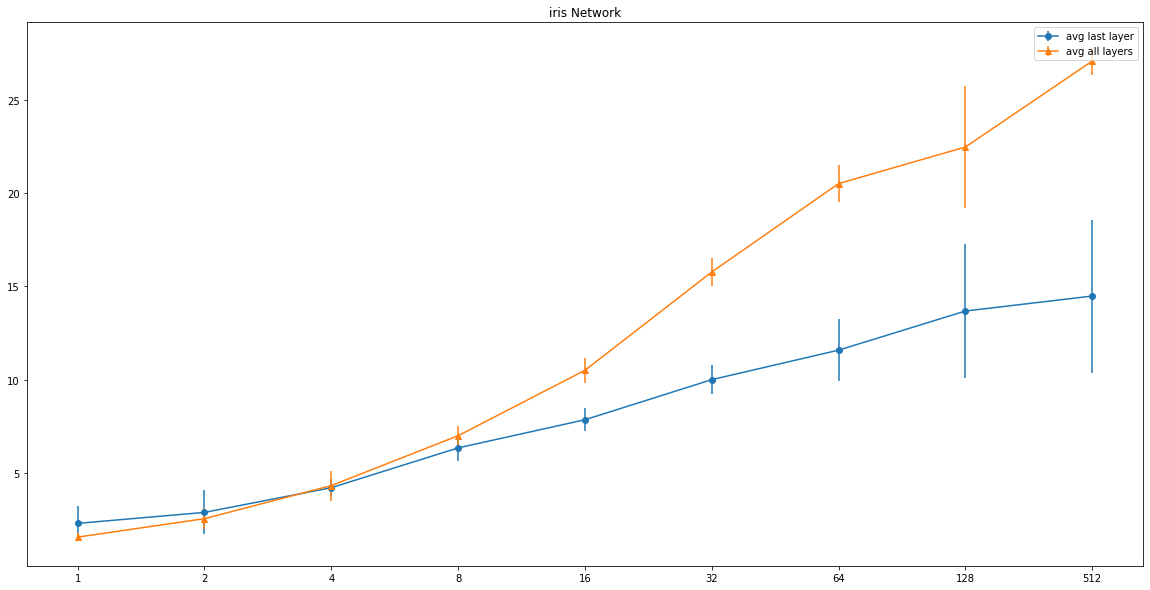

In [215]:
width = ['1', '2', '4', '8', '16', '32', '64', '128', '512']
fig = plt.errorbar(width, llmean[::-1], llstd[::-1], linestyle = 'solid',fmt='o')
fig.set_label('avg last layer')
fig = plt.errorbar(width, avgmean[::-1], avgstd[::-1], marker='^')
fig.set_label('avg all layers')
plt.title('iris Network')
plt.legend()
plt.show()


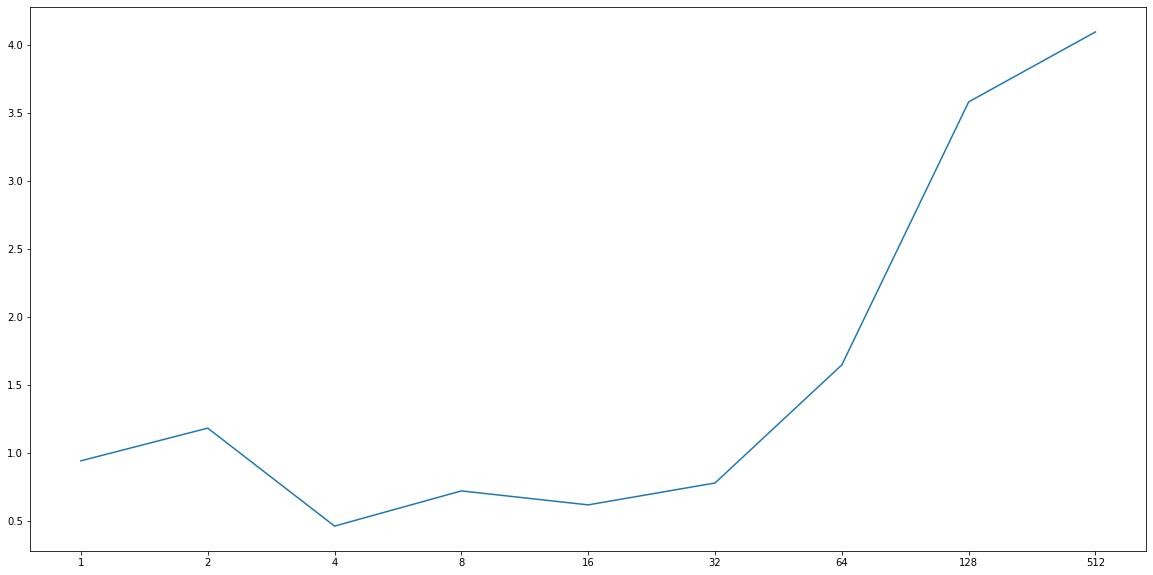

In [219]:
plt.plot(width, llstd[::-1])

(0.1, 1.1)

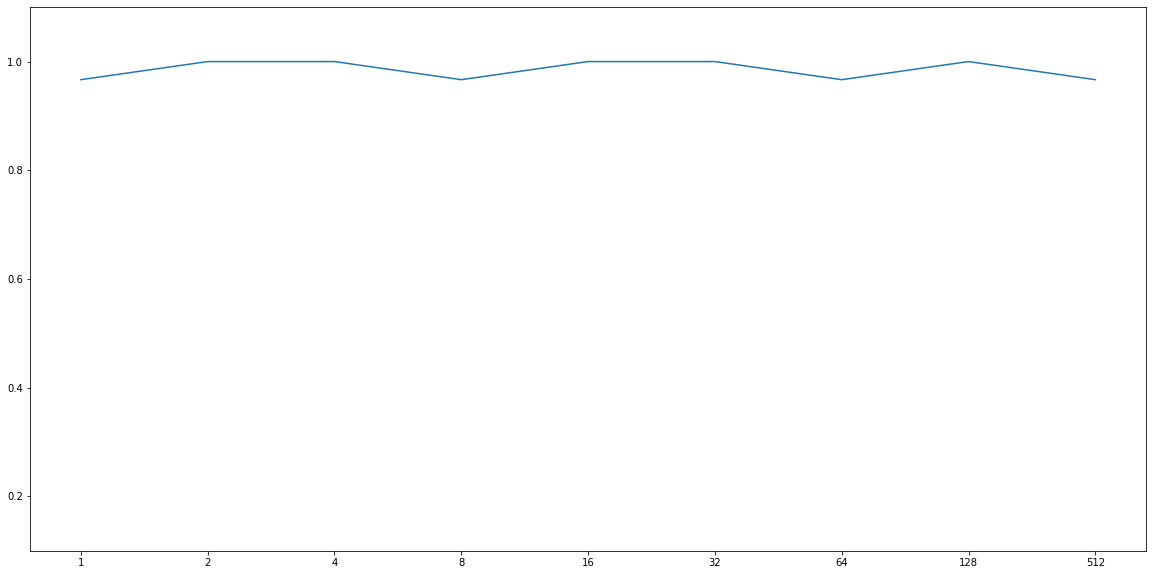

In [220]:
plt.plot(width, meanacc)
plt.ylim(0.1, 1.1)